## 13. Covid 19 spatial epidemiological model: final project

In this class, we will introduce a _spatial epidemiological model_, looking at how urban population density and urban mobility patterns can be incorporated in such models to describe the spread of the Covid-19 epidemic in a city. We will look at the mathematics of the model, and code the core engine for the model to run simulations of the Covid-19 epidemic in Yerevan city.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [2]:
# in case of encountering problems with GEOS or GDAL, disable speedups from shapely
from shapely import speedups
speedups.disable()

Let's start by loading the Yerevan subdivided grid cell data we had prepared earlier.

In [3]:
from pyproj import CRS
crs = CRS.from_epsg(4326)

yerevan_gdf = gpd.read_file('../data/Yerevan grid shapefile/yerevan.shp')
yerevan_gdf.head()

,FID,geometry
0,0,"POLYGON ((44.41298 40.18969, 44.41155 40.19399..."
1,1,"POLYGON ((44.41772 40.18316, 44.41418 40.18603..."
2,2,"POLYGON ((44.42035 40.18107, 44.42025 40.18110..."
3,3,"POLYGON ((44.42598 40.17664, 44.42576 40.17920..."
4,4,"POLYGON ((44.42652 40.17009, 44.42598 40.17664..."


In [4]:
print(yerevan_gdf.crs)

None


In [5]:
yerevan_gdf.set_crs(epsg=4326, inplace=True)
print(yerevan_gdf.crs)

epsg:4326


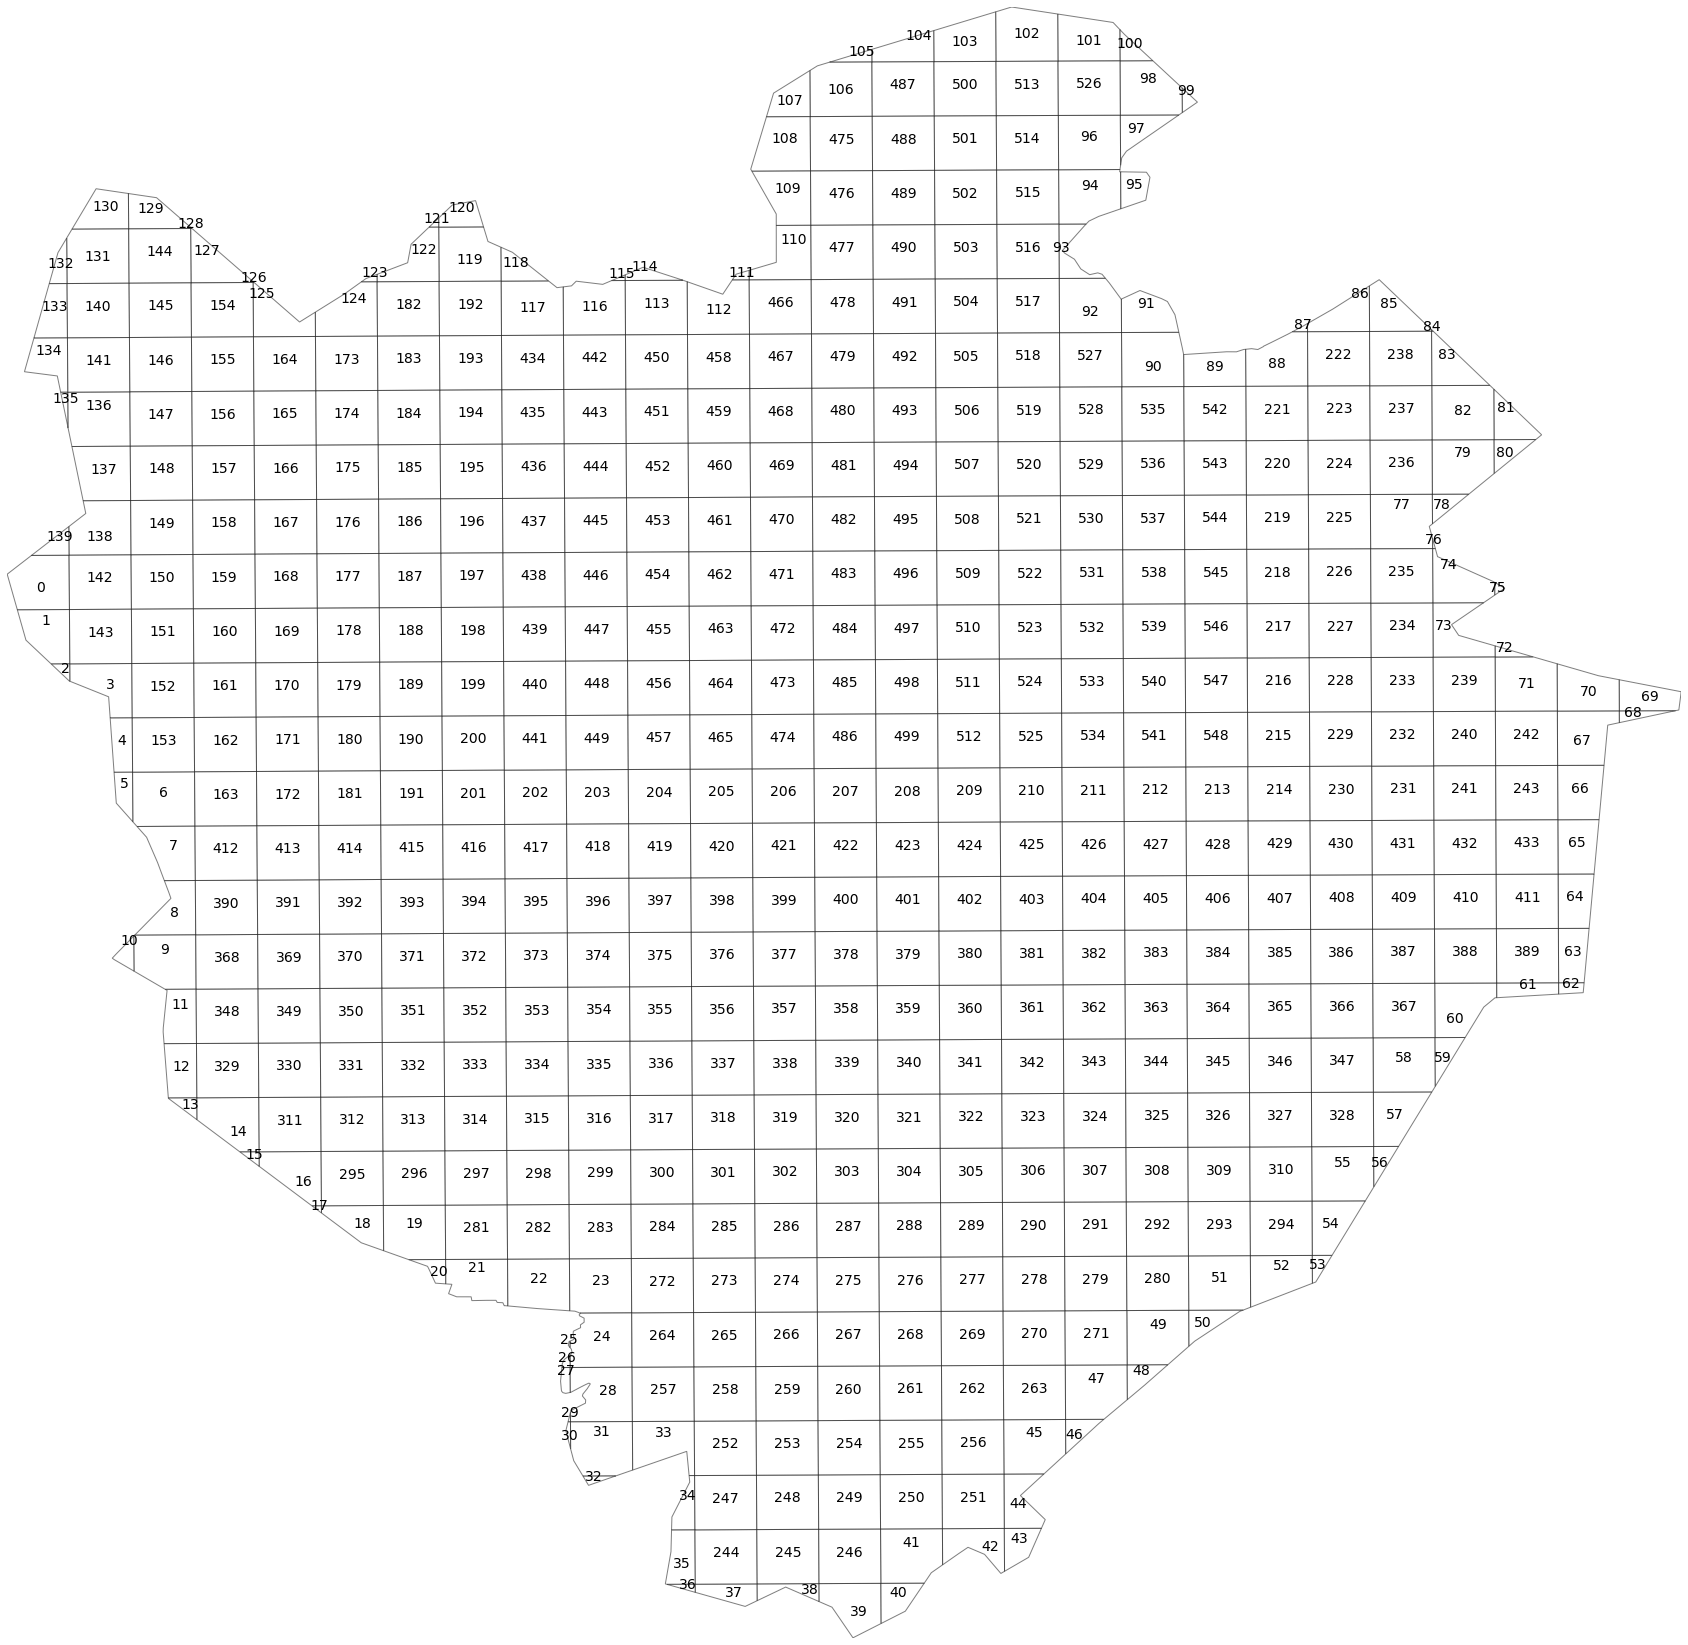

In [6]:
polylist = [p for p in yerevan_gdf.geometry]

# plot city
west, south, east, north = yerevan_gdf.unary_union.bounds

fig, ax = plt.subplots(figsize=(30,30))
for polygon, n in zip(yerevan_gdf.geometry, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p, horizontalalignment='center', size=14)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

Now, let's load the Yerevan population density data:

In [7]:
import pickle
pkl_file = open("../data//Yerevan_grid_population.pkl", "rb")
yerevan_pop = pickle.load(pkl_file)
pkl_file.close()
print(yerevan_pop)

[    0.             0.             0.             0.
     0.             0.             0.             0.
   727.53728629     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.          3839.78012206
     0.             0.             0.             0.
     0.             0.             0.             0.
  2020.93690635     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.          1050.8871913
     0.             0.             0.             0.
     0.             0.         

In [8]:
yerevan_pop.shape

(549,)

In [9]:
yerevan_pop.sum()

1000000.0

Let's plot a quick histogram of the population density in Yerevan:

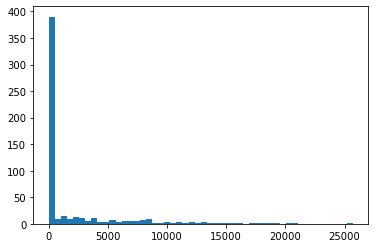

In [10]:
plt.hist(yerevan_pop, bins=50)
plt.show()

In [11]:
print('yerevan geodataframe length: ', len(yerevan_gdf))
print('Yerevan population array length: ', len(yerevan_pop))

yerevan geodataframe length:  549
Yerevan population array length:  549


In [12]:
yerevan_gdf['population'] = yerevan_pop
yerevan_gdf.head()

,FID,geometry,population
0,0,"POLYGON ((44.41298 40.18969, 44.41155 40.19399...",0.0
1,1,"POLYGON ((44.41772 40.18316, 44.41418 40.18603...",0.0
2,2,"POLYGON ((44.42035 40.18107, 44.42025 40.18110...",0.0
3,3,"POLYGON ((44.42598 40.17664, 44.42576 40.17920...",0.0
4,4,"POLYGON ((44.42652 40.17009, 44.42598 40.17664...",0.0


Let's plot the population density on a map:

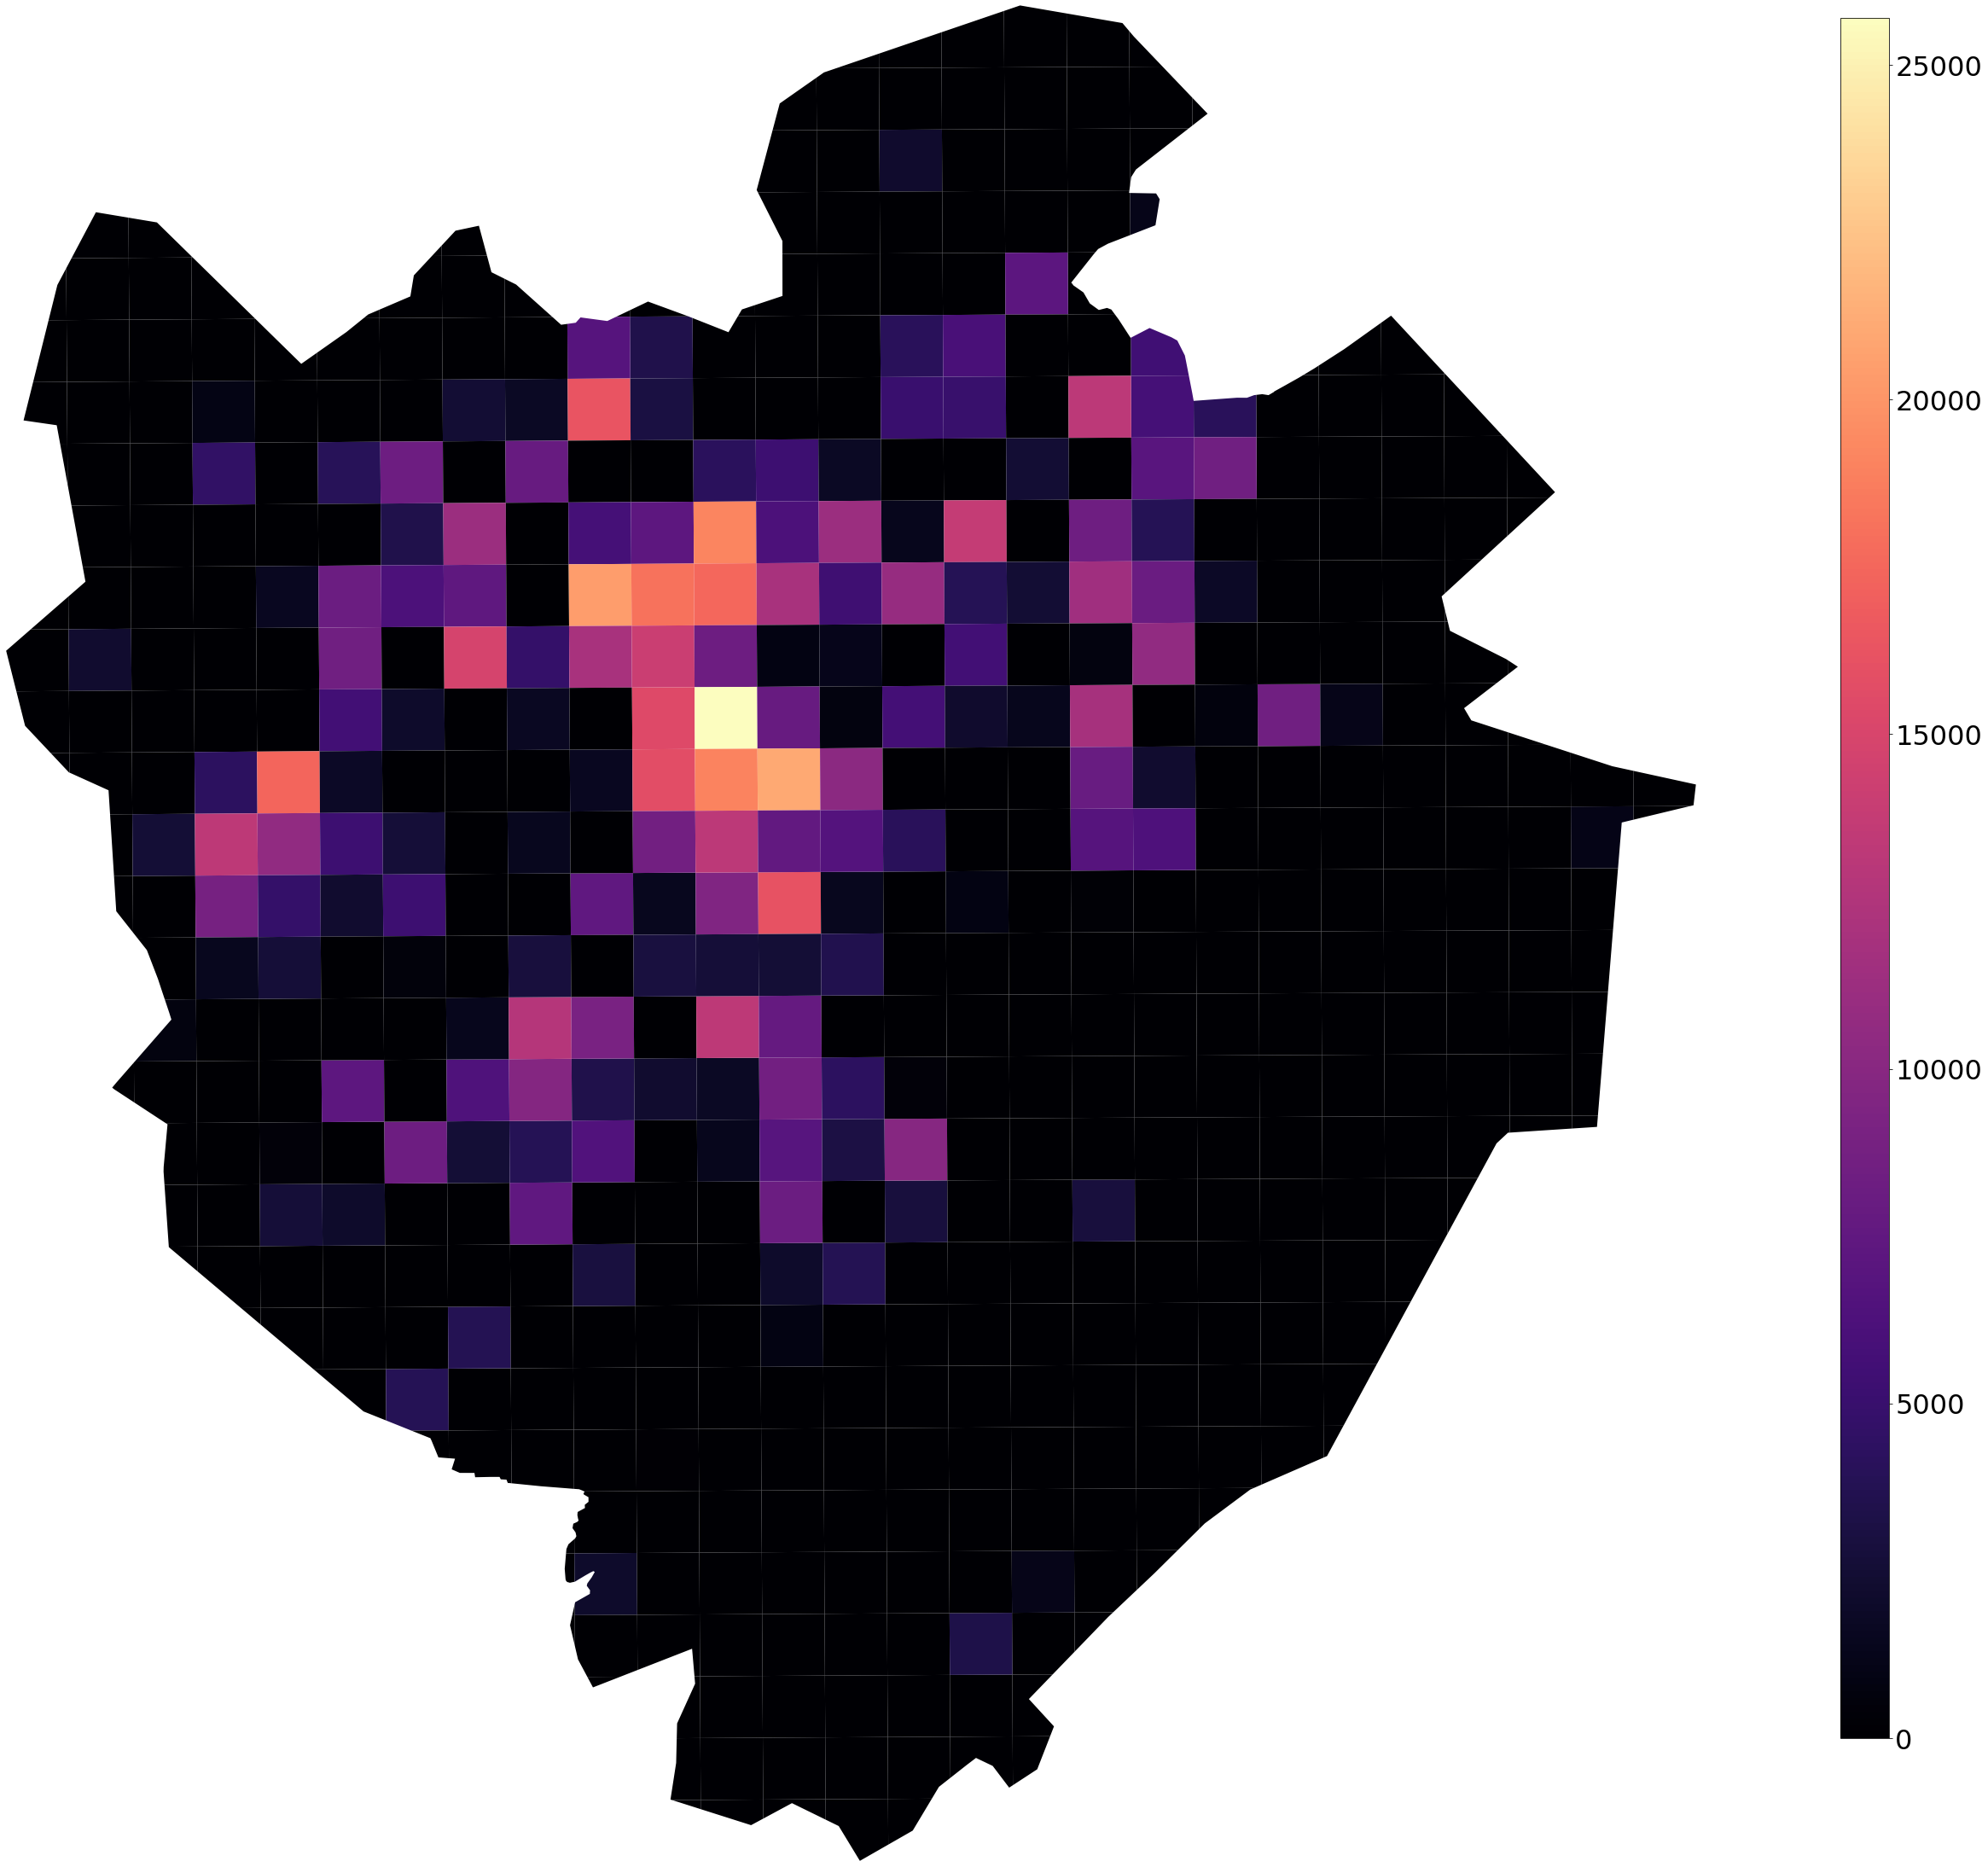

In [13]:
plt.rcParams.update({'font.size':32})
west, south, east, north = yerevan_gdf.unary_union.bounds

fig, ax = plt.subplots(figsize=(40,40))
yerevan_gdf.plot(ax=ax, column = 'population', legend=False, cmap='magma')

cbax = fig.add_axes([0.915, 0.175, 0.02, 0.7])

sm = plt.cm.ScalarMappable(cmap='magma', \
                          norm = plt.Normalize(vmin=min(yerevan_gdf.population), vmax=max(yerevan_gdf.population)))

sm._A = []

# draw colormap into cbax

fig.colorbar(sm, cax=cbax, format="%d")

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

Now, let's load the temporally dynamic population densities in Yerevan:

In [14]:
np.set_printoptions(suppress=True, precision=3)

# load population densities
pkl_file = open('../data/Yerevan_population.pkl', 'rb')
pop = pickle.load(pkl_file)
pkl_file.close()
print(pop.shape)
print(pop)

(84, 549)
[[  0.      0.      0.    ... 717.269   0.      0.   ]
 [  0.      0.      0.    ... 791.557   0.      0.   ]
 [  0.      0.      0.    ... 834.591   0.      0.   ]
 ...
 [  0.      0.      0.    ... 872.206   0.      0.   ]
 [  0.      0.      0.    ... 760.611   0.      0.   ]
 [  0.      0.      0.    ... 539.288   0.      0.   ]]


Let's check that the sums across all polygon grid cells equal 1 million at all times:

In [15]:
pop.sum(1)

array([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 1000000.])

Finally, let's load the Origin-Destination matrices data encoding the hourly urban mobility patterns in Yerevan city:

In [16]:
pkl_file = open("../data/Yerevan_OD_matrices.pkl", "rb")
OD_matrices = pickle.load(pkl_file)
pkl_file.close()
print(OD_matrices)

[[[ 42.   0.   0. ...   0.   0.   0.]
  [  0.  42.   0. ...   0.   0.   0.]
  [  0.   0.  42. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 853.   0.   0.]
  [  0.   0.   0. ...   0.  42.   0.]
  [  0.   0.   0. ...   0.   0.  42.]]

 [[ 76.   0.   0. ...   0.   0.   0.]
  [  0.  76.   0. ...   0.   0.   0.]
  [  0.   0.  76. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 765.   0.   0.]
  [  0.   0.   0. ...   0.  76.   0.]
  [  0.   0.   0. ...   0.   0.  76.]]

 [[ 63.   0.   0. ...   0.   0.   0.]
  [  0.  63.   0. ...   0.   0.   0.]
  [  0.   0.  63. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 765.   0.   0.]
  [  0.   0.   0. ...   0.  63.   0.]
  [  0.   0.   0. ...   0.   0.  63.]]

 ...

 [[ 17.   0.   0. ...   0.   0.   0.]
  [  0.  17.   0. ...   0.   0.   0.]
  [  0.   0.  17. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 444.   0.   0.]
  [  0.   0.   0. ...   0.  17.   0.]
  [  0.   0.   0. ...   0.   0.  17.]]

 [[ 20.   0.   0. ...   0.   0.   0.]
  [  0.  20.

In [17]:
OD_matrices.shape

(84, 549, 549)

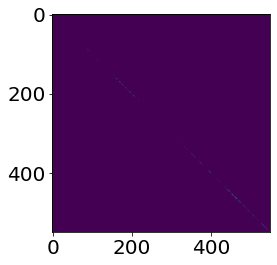

In [18]:
plt.rcParams.update({'font.size':20})
plt.imshow(OD_matrices[12], cmap='viridis')
plt.show()

In [19]:
print("On-diagonal sum: ", np.diagonal(OD_matrices[12]).sum())
print("Off-diagonal sum: ", OD_matrices[12].sum() - np.diagonal(OD_matrices[12]).sum())

On-diagonal sum:  950002.0
Off-diagonal sum:  49144.0


### The Covid-19 model

For the purposes of this class, we are going to use a [compartmental epidemiological model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology), which we are going to modify to include urban mobility patterns, making the model explicitly spatial.

<img src="images/SEIR.png">

$$
\begin{equation}
\begin{aligned}
S_{j, t+1} &=S_{j, t} - S_{j, t}\frac{ I_{j, t}}{P_{j}} \frac{R_0}{D_{I}} + \sum_{k} s_{j, k}^{t} \alpha_{j, k}^{t} - \sum_{k} s_{k, j}^{t} \alpha_{k, j}^{t} \\
E_{j, t+1} &=E_{j, t} + S_{j, t}\frac{ I_{j, t}}{P_{j}} \frac{R_0}{D_{I}} - \frac{E_{j, t}}{D_{E}} + \sum_{k} e_{j, k}^{t} \alpha_{j, k}^{t} - \sum_{k} e_{k, j}^{t} \alpha_{k, j}^{t} \\
I_{j, t+1} &=I_{j, t} + \frac{E_{j, t}}{D_{E}} - \frac{I_{j, t}}{D_{I}} + \sum_{k} i_{j, k}^{t} \alpha_{j, k}^{t} - \sum_{k} i_{k, j}^{t} \alpha_{k, j}^{t} \\
R_{j, t+1} &=R_{j, t} + \frac{I_{j, t}}{D_{I}} + \sum_{k} r_{j, k}^{t} \alpha_{j, k}^{t} - \sum_{k} r_{k, j}^{t} \alpha_{k, j}^{t},
\end{aligned}
\end{equation}
$$

where 

* $P_{j}$ is the population in cell $j$,
* $R_0$ is the [basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number),
* $D_{E}$ is the **incubation period**, i.e., $t_{first symptom} - t_{infected}$, with the assumption that during the incubation period the disease can't be transmitted (which is not the case in real life!)
* $D_{I}$ is the **infection period**, i.e., the period the person can infect others,
* $s_{j, k}^{t}$ is the number of susceptible people that went from cell $k$ to cell $j$ at time $t$,
* $\alpha_{j, k}^{t}$ is a parameter specifying the quarantine strength.

Let's jum straight into coding the model:

In [20]:
from collections import namedtuple

Param = namedtuple('Param', 'R0 DE DI I0 HospitalisationRate HospiterIters')
# I0 is the distribution of infected people at time t=0,
# if None then randomly choose inf number of people

In [21]:
OD_matrices.shape

(84, 549, 549)

In [22]:
# flow is a 3D matrix of dimensions r x n x n (i.e., 84 x 549 x 549),
# flow[t mod r] is the desired OD matrix at time t.

def seir(par, distr, flow, alpha, iterations, inf):
    
    """
    function input: 
    
    par: model parameters as namedtuple
    distr: city population distribution across different 2-hour periods, 84 x 549
    flow: Origin-Destination matrices as a 3D matrix of dimensions r x n x n (i.e., 84 x 549 x 549)
    alpha: quarantine strength, float in the range [0, 1]
    iterations: number of iterations the simulation should run. iterations/12 is the number of days
    inf: number of initial random infections
    
    function output: 
    
    res: 2D numpy array of size (iterations, 5)
    history: 2D numpy array of size (iterations, 5, len(yerevan_gdf))
    
    """
    
    r = flow.shape[0]  # number of two-hour intervals
    n = flow.shape[1]  # number of grid cells
    N = distr[0].sum() # total population, we assume that N = sum(flow)
    
    Svec = distr[0].copy()
    Evec = np.zeros(n)
    Ivec = np.zeros(n)
    Rvec = np.zeros(n)
    
    if par.I0 is None:
        initial = np.zeros(n)
        # randomly choose inf infections
        for i in range(inf):
            loc = np.random.randint(n)
            if (Svec[loc] > initial[loc]):
                initial[loc] += 1.0
                
    else:
        initial = par.I0
    assert ((Svec < initial).sum() == 0)
    
    Svec =- initial
    Ivec =+ initial
    
    res = np.zeros((iterations, 5))
    res[0,:] = [Svec.sum(), Evec.sum(), Ivec.sum(), Rvec.sum(), 0]
    
    realflow = flow.copy() # copy!
    
#     for j in range(r):
#         for i in range(n):
#             realflow[j][i] /= realflow[j][i].sum()

    # The two lines below normalise the flows and then multiply them by the alpha values. 
    # This is actually the "wrong" the way to do it because alpha will not be a *linear* measure 
    # representing lockdown strength but a *nonlinear* one.
    # The normalisation strategy has been chosen for demonstration purposes of numpy functionality.
    
    realflow = realflow / realflow.sum(axis=2)[:,:, np.newaxis]    
    realflow = alpha * realflow    
    
    history = np.zeros((iterations, 5, n))
    history[0,0,:] = Svec
    history[0,1,:] = Evec
    history[0,2,:] = Ivec
    history[0,3,:] = Rvec
    
    eachIter = np.zeros(iterations + 1)
    
    # run simulation
    for iter in range(0, iterations - 1):
        realOD = realflow[iter % r]
        
        d = distr[iter % r] + 1
        
        if ((d>N+1).any()): #assertion!
            print("Houston, we have a problem!")
            return res, history
        # N =  S + E + I + R
        
        newE = Svec * Ivec / d * par.R0 / par.DI
        newI = Evec / par.DE
        newR = Ivec / par.DI
        
        Svec -= newE
        Svec = (Svec 
               + np.matmul(Svec.reshape(1,n), realOD)
               - Svec * realOD.sum(axis=1)
                )
        Evec = Evec + newE - newI
        Evec = (Evec 
               + np.matmul(Evec.reshape(1,n), realOD)
               - Evec * realOD.sum(axis=1)
                )
                
        Ivec = Ivec + newI - newR
        Ivec = (Ivec 
               + np.matmul(Ivec.reshape(1,n), realOD)
               - Ivec * realOD.sum(axis=1)
                )
                
        Rvec += newR
        Rvec = (Rvec 
               + np.matmul(Rvec.reshape(1,n), realOD)
               - Rvec * realOD.sum(axis=1)
                )
                
        res[iter + 1,:] = [Svec.sum(), Evec.sum(), Ivec.sum(), Rvec.sum(), 0]
        eachIter[iter + 1] = newI.sum()
        res[iter + 1, 4] = eachIter[max(0, iter - par.HospiterIters) : iter].sum() * par.HospitalisationRate
        
        history[iter + 1,0,:] = Svec
        history[iter + 1,1,:] = Evec
        history[iter + 1,2,:] = Ivec
        history[iter + 1,3,:] = Rvec
        
        
    return res, history

### Homework assignment

Start coding the Covid 19 spatial epidemiological model described in this Notebook by building Origin-Destination matrices from the Yerevan GG data.

Complete the homework assignment in a clean Jupyter Notebook, name the notebook **< Name > < Surname > Classes 13-14 Homework** and upload it to Moodle.

Note: The homework assignments for classes 13 and 14 should be completed together in one Notebook.